# SpaceRocks

### Vectorized coordinate transformation and ephemeris calculation with robust unit handling.

To install, simply `pip install spacerocks`

In [1]:
from spacerocks import Units, SpaceRock, Observe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import units as u
%matplotlib inline

from astroquery.jplhorizons import Horizons

In [2]:
units = Units()
units.timescale = 'tdb'
TNO = SpaceRock(a=4.487673062316562E+02,
                e=9.214543710796702E-01,
                inc=5.411068217470999E+01,
                arg=3.480587931444684E+02,
                node=1.352131434907198E+02,
                t_peri=2473015.776611103211,
                epoch=2458982.5,
                input_frame='barycentric',
                units=units)

In [ ]:
o = Observe(TNO, obscode='807')
o.ra.hms, o.dec.dms, o.delta

In [ ]:
o.ra.deg

In [ ]:
o = Observe(TNO)
o.ra.hms, o.dec.dms, o.delta

You can also pass in just a single object or an array of objects. I'll try all of the TNOs reported to the MPC. I specified an observatory code, so a topocentric correction will be applied to the Earth's position.

In [ ]:
Nyears = 1
startdate = Time('2021-01-01', scale='utc', format='iso')
testdates = Time(np.arange(startdate.jd, startdate.jd + Nyears*365.25, 10), scale='utc', format='jd' )
tno_id = '2015 BP519'
TNO_Horizons = Horizons(id=tno_id, location='@ssb')
elements = TNO_Horizons.elements()[0]
ephem_Horizons = Horizons(id=tno_id, location='500',
                          epochs={'start':testdates[0].iso, 'stop':testdates[-1].iso, 'step':'10d'}).ephemerides()

In [ ]:
units = Units()
TNO = SpaceRock(a=elements['a'],
                e=elements['e'],
                inc=elements['incl'],
                arg=elements['w'],
                node=elements['Omega'],
                M=elements['M'],
                epoch=elements['datetime_jd'],
                name=[tno_id],
                input_frame='barycentric',
                units=units)
TNO.epoch.jd

In [ ]:
TNO_prop = TNO.propagate(obsdates=testdates.jd, model=6)
#o = Observe(TNO_prop)
#o.ra.deg, o.dec.deg

In [ ]:
epochs = {'start':testdates[0].iso, 'stop':testdates[-1].iso, 'step':'10d'}
elem = Horizons(id=tno_id, epochs=epochs, location='@ssb').elements()

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['a'], color='black', s=50, label='Horizons')
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.a, color='red', s=10, label='Me')
ax.set_xlabel('t - t0 (years)', fontsize=14)
ax.set_ylabel('a', fontsize=14)
ax.set_xlim([0, Nyears])
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['incl'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.inc.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('inc', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['e'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.e, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('e', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['w'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.arg.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel(r'$\omega$', fontsize=14)
ax.set_xlim([0, Nyears])

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['Omega'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.node.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel(r'$\omega$', fontsize=14)
ax.set_xlim([0, Nyears])

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['M'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.M.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel(r'$M$', fontsize=14)
ax.set_xlim([0, Nyears])

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['nu'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.true_anomaly.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel(r'$\nu$', fontsize=14)
ax.set_xlim([0, Nyears])

In [ ]:
TNO_predict = Observe(TNO_prop, obscode='W84')

In [ ]:
pos_Horizons = SkyCoord(ephem_Horizons['RA'], ephem_Horizons['DEC'], frame='icrs', unit=(u.deg, u.deg))
pos_pred = SkyCoord(TNO_predict.ra.deg, TNO_predict.dec.deg, frame='icrs', unit=(u.deg, u.deg))
sep = pos_pred.separation(pos_Horizons)

In [ ]:
plt.scatter(ephem_Horizons['RA'], ephem_Horizons['DEC'])

In [ ]:
plt.scatter(TNO_predict.ra.deg, TNO_predict.dec.deg)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['RA'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.ra.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('ra', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['DEC'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.dec.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('dec', fontsize=14)
ax.set_xlim([0, Nyears]);

---

### Analyzing all of the TNOs in the MPC

In [ ]:
TNOs = pd.read_json('https://minorplanetcenter.net/Extended_Files/distant_extended.json.gz')

TNOs = TNOs[TNOs.Principal_desig.values.astype(str) == '2015 BP519']
units = Units()
rocks = SpaceRock(a=TNOs.a.values, 
                  e=TNOs.e.values, 
                  inc=TNOs.i.values, 
                  arg=TNOs.Peri.values, 
                  node=TNOs.Node.values, 
                  t_peri=TNOs.Tp.values, 
                  epoch=TNOs.Epoch.values,
                  H=TNOs.H.values, 
                  name=TNOs.Principal_desig.values,
                  #delta_H = np.random.rand(len(TNOs)),
                  #rotation_period = np.random.uniform(0.2, 0.5, len(TNOs)),
                  #phi0 = np.random.rand(len(TNOs)) * 2 * np.pi,
                  input_frame='heliocentric',
                  units=units)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['RA_rate'], color='black', s=50)
ax[0].scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.ra_rate.to(u.arcsec/u.h), color='red', s=10)
ax[0].set_xlabel('JD', fontsize=14)
ax[0].set_ylabel('ra rate (arcsec/h)', fontsize=14)
ax[0].set_xlim([0, Nyears]);

ax[1].scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['DEC_rate'], color='black', s=50)
ax[1].scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.dec_rate.to(u.arcsec/u.h), color='red', s=10)
ax[1].set_xlabel('JD', fontsize=14)
ax[1].set_ylabel('dec rate (arcsec/h)', fontsize=14)
ax[1].set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].scatter((testdates.jd - testdates.jd[0])/365.25, 
              ephem_Horizons['RA_rate'] - TNO_predict.ra_rate.to(u.arcsec/u.h), color='black', s=1)
ax[0].set_xlabel('JD', fontsize=14)
ax[0].set_ylabel('ra rate (arcsec/h)', fontsize=14)
ax[0].set_xlim([0, Nyears]);

ax[1].scatter((testdates.jd - testdates.jd[0])/365.25, 
              ephem_Horizons['DEC_rate'] - TNO_predict.dec_rate.to(u.arcsec/u.h), color='black', s=1)
ax[1].set_xlabel('JD', fontsize=14)
ax[1].set_ylabel('dec rate (arcsec/h)', fontsize=14)
ax[1].set_xlim([0, Nyears]);

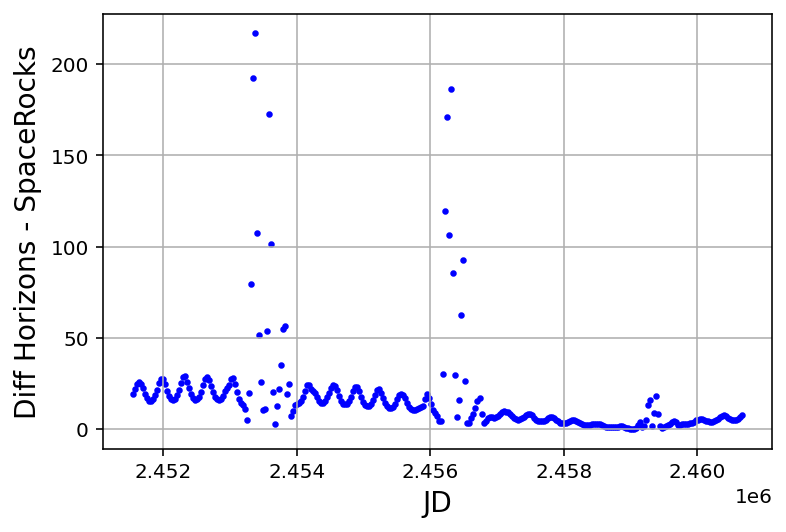

In [6]:
startdate = Time('2000-01-01', scale='utc', format='iso')
testdates = Time(np.arange(startdate.jd, startdate.jd + 25*365.25, 30), scale='utc', format='jd' )
tno_id = 'Apophis'
TNO_Horizons = Horizons(id=tno_id, location='@ssb')
elements = TNO_Horizons.elements()[0]
ephem_Horizons = Horizons(id=tno_id, location='W84',
                          epochs={'start':testdates[0].iso, 'stop':testdates[-1].iso, 'step':'30d'}).ephemerides()
TNO = SpaceRock(a=elements['a'],
                  e=elements['e'],
                  inc=elements['incl'],
                  arg=elements['w'],
                  node=elements['Omega'],
                  t_peri=elements['Tp_jd'],
                  epoch=elements['datetime_jd'],
                  name=[tno_id],
                  input_frame='barycentric')

p = TNO.propagate(obsdates=testdates.jd, model=6, add_pluto=True, gr=True)
TNO_predict = Observe(p, obscode='W84')
pos_Horizons = SkyCoord(ephem_Horizons['RA'], ephem_Horizons['DEC'], frame='icrs', unit=(u.deg, u.deg))
pos_pred = SkyCoord(TNO_predict.ra.deg, TNO_predict.dec.deg, frame='icrs', unit=(u.deg, u.deg))
sep = pos_pred.separation(pos_Horizons)

plt.scatter(testdates.jd, sep.arcsec, color='b', s=5)
plt.xlabel('JD', fontsize=14)
plt.ylabel('Diff Horizons - SpaceRocks', fontsize=14)
plt.grid()